In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train_BRCpofr.csv')
df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


Os dados podem ser econtrados [aqui](https://www.kaggle.com/datasets/shibumohapatra/customer-life-time-value?select=train_BRCpofr.csv)

id-Unique identifier of a customer  
gender-Gender of the customer   
area-Area of the customer   
qualification-Highest Qualification of the customer     
income-Income earned in a year (in rupees)  
marital_status-Marital Status of the customer {0:Single, 1: Married}    
vintage-No. of years since the first policy date    
claim_amount-Total Amount Claimed by the customer (in rupees)   
num_policies-Total no. of policies issued by the customer   
policy-Active policy of the customer    
type_of_policy-Type of active policy    
cltv- Customer lifetime value (Target Variable) 

# EDA

In [3]:
print(df.shape)
print(df.isna().sum())

(89392, 12)
id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64


In [4]:
for column in df.columns:
    if column == 'id' or column == 'claim_amount' or column == 'cltv':
        pass
    else:
        print(f'{column}:  {df[column].unique()}')

gender:  ['Male' 'Female']
area:  ['Urban' 'Rural']
qualification:  ['Bachelor' 'High School' 'Others']
income:  ['5L-10L' 'More than 10L' '2L-5L' '<=2L']
marital_status:  [1 0]
vintage:  [5 8 7 6 1 0 3 4 2]
num_policies:  ['More than 1' '1']
policy:  ['A' 'C' 'B']
type_of_policy:  ['Platinum' 'Gold' 'Silver']


Logo de cara imagino que para o type of policy eu possa usar o Ordinal Encoder, já que acredito que existirá uma relação positiva entre o tipo e o cltv. Claro que irei confirmar primeiro.     
Já para as outras variáveis categóricas, será necessário aprofundar em cada uma.

Uma das primeiras coisas que me chamou atenção quando abri o df foi a questão do income estar sendo passado como range, então primeiro irei explorar apenas ele para decidir como prosseguir

In [19]:
incomes_counts_policy = df.groupby(['income', 'type_of_policy'])['income'].count()
incomes_counts_policy

income         type_of_policy
2L-5L          Gold               4462
               Platinum          10908
               Silver             5788
5L-10L         Gold              12544
               Platinum          28610
               Silver            11562
<=2L           Gold                294
               Platinum           1042
               Silver              518
More than 10L  Gold               3286
               Platinum           7236
               Silver             3142
Name: income, dtype: int64

In [31]:
incomes_counts = df.groupby('income')['income'].count()
incomes_counts

,income,cltv
income,,
2L-5L,21158,21158
5L-10L,52716,52716
<=2L,1854,1854
More than 10L,13664,13664


<AxesSubplot: xlabel='income'>

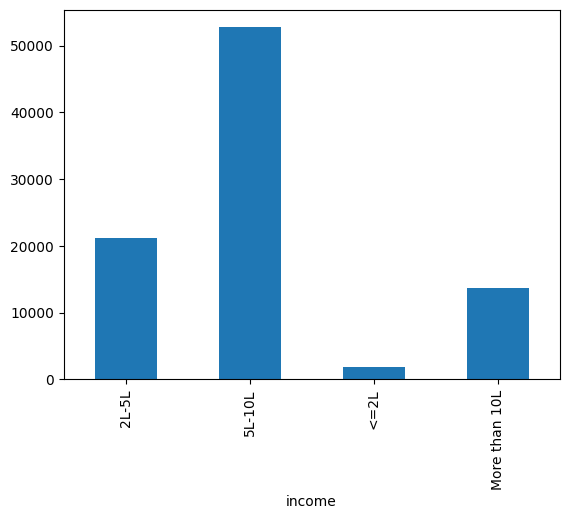

In [29]:
incomes_counts.plot(kind='bar')

<AxesSubplot: xlabel='income,type_of_policy'>

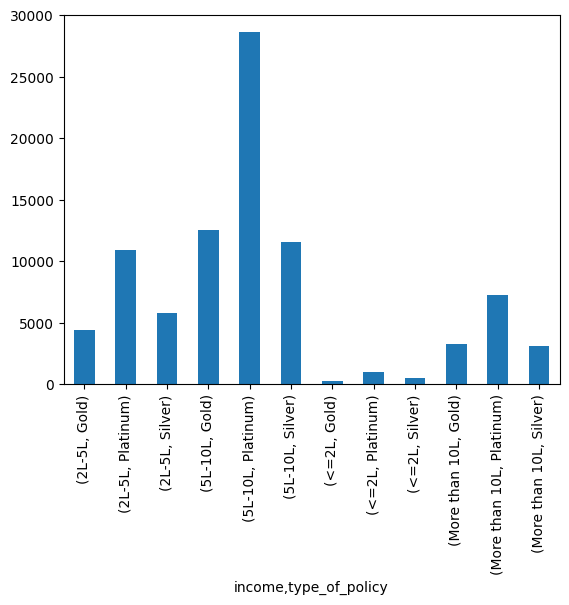

In [30]:
incomes_counts_policy.plot(kind='bar')

Podemos notar que em todos os o tipo seguro que predodomina é o platina.

In [33]:
cltv_by_income_policy = df.groupby(['income', 'type_of_policy'])['cltv'].sum()
cltv_by_income_policy

income         type_of_policy
2L-5L          Gold               491606004
               Platinum          1233512532
               Silver             590992884
5L-10L         Gold              1227635064
               Platinum          2762199048
               Silver            1021449360
<=2L           Gold                31918116
               Platinum           117362148
               Silver              57337164
More than 10L  Gold               294718320
               Platinum           654718764
               Silver             272749884
Name: cltv, dtype: int64

<AxesSubplot: xlabel='income,type_of_policy'>

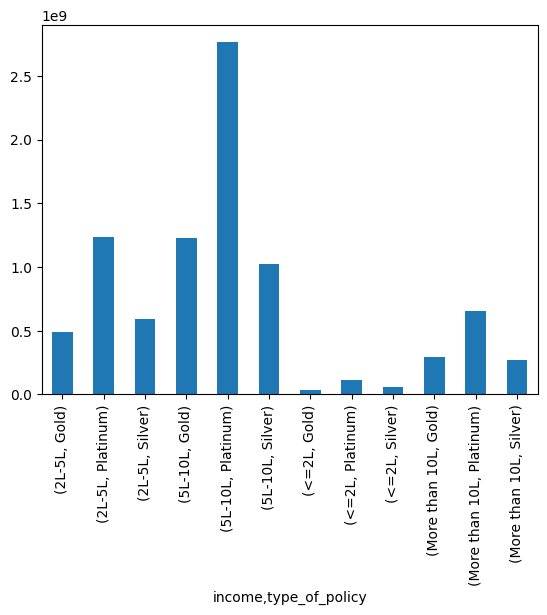

In [34]:
cltv_by_income_policy.plot(kind='bar')

Também como era de se imaginar são os que tem um cltv maior também.

In [41]:
df.groupby(['income', 'type_of_policy'])['cltv'].median()

income         type_of_policy
2L-5L          Gold              67518.0
               Platinum          69132.0
               Silver            67386.0
5L-10L         Gold              66240.0
               Platinum          66120.0
               Silver            64884.0
<=2L           Gold              66504.0
               Platinum          68874.0
               Silver            66174.0
More than 10L  Gold              65490.0
               Platinum          65670.0
               Silver            65634.0
Name: cltv, dtype: float64

<AxesSubplot: xlabel='income', ylabel='cltv'>

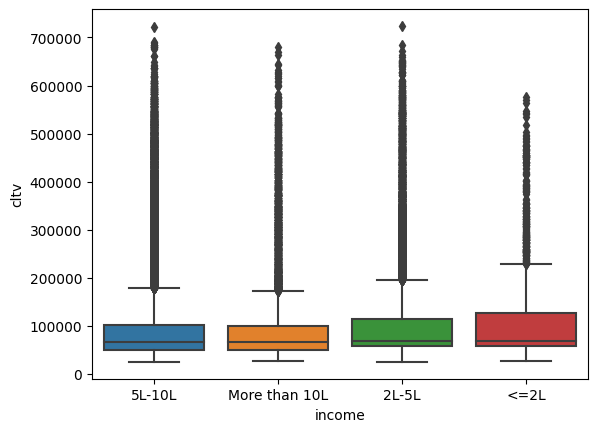

In [48]:
sns.boxplot(data=df, x='income', y='cltv')

<AxesSubplot: xlabel='income', ylabel='cltv'>

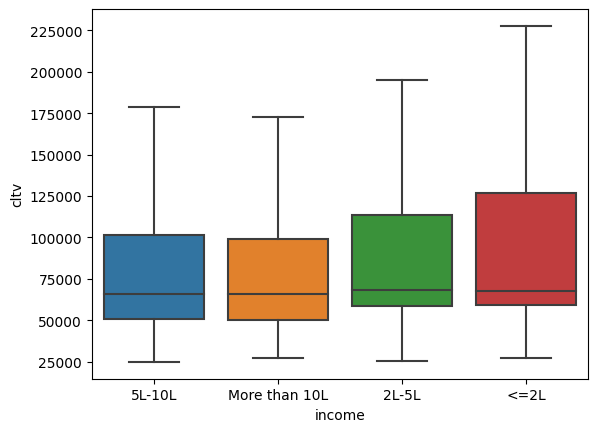

In [49]:
sns.boxplot(data=df, x='income', y='cltv', showfliers=False)

Incialmente os outliers assustam, mas podemos ficar mais "tranquilos" se levarmos em consideração à fórmula de como são encontrados os mesmos: [Q1 - k (Q3 - Q1), Q3 + k(Q3-Q1)]    
O que significa que a mediana junto com os quartis tem uma forte influencia.    
Como estamos falando de seguro eu presumo que isso ocorra porque a maior parte dos carros que circulam em qualquer cidade são populares, fazendo assim com que não tenham um custo de seguro tão elevado, o que faz com que existam médias realmente diferentes entre cada tipo de seguro ou renda, mas a mediana tende a se aproxima seguindo  a lógica de carros populares.
Mesmo assim vamos precisar verificar mais a fundo alguns valores.